>### Assignment - 4
>
> ----
>#### Name: Balkrishna Sehra
>#### Roll no: 24210022
>
> ___

In [2]:
### Imports
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
## Data Preparation

return # Comment this when need to run
# Directories where your images are stored
source_dirs = ['./duckduckgo_images/Bobcat', './duckduckgo_images/Jackal']
base_output_dir = Path('dataset')

# Train-test split ratio
train_ratio = 0.8  # 80% training, 20% testing

def split_data(source_dir, output_dir, train_ratio):
    # Create train and test directories if not present
    train_dir = output_dir / 'train' / source_dir.split('/')[-1]
    test_dir = output_dir / 'test' / source_dir.split('/')[-1]

    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)

    # List all image files in the source directory
    image_files = list(Path(source_dir).glob('*.jpg')) + list(Path(source_dir).glob('*.jpeg')) + list(Path(source_dir).glob('*.png'))
    
    # Split data into train and test sets
    train_files, test_files = train_test_split(image_files, train_size=train_ratio, random_state=42)

    # Move images to train directory
    for file_path in train_files:
        shutil.copy2(file_path, train_dir / file_path.name)
    
    # Move images to test directory
    for file_path in test_files:
        shutil.copy2(file_path, test_dir / file_path.name)
    
    print(f"Moved {len(train_files)} images to {train_dir}")
    print(f"Moved {len(test_files)} images to {test_dir}")

def main():
    if not base_output_dir.exists():
        base_output_dir.mkdir(parents=True)
    
    for source_dir in source_dirs:
        split_data(source_dir, base_output_dir, train_ratio)

if __name__ == "__main__":
    main()


SyntaxError: 'return' outside function (3434550180.py, line 3)

#### Preprocessing 

In [4]:

return # Comment this when need to run
# Define the preprocessing transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet standards
])

# Function to preprocess images in a directory
def preprocess_images(input_dir, output_dir):
    input_path = Path(input_dir)
    output_path = Path(output_dir)

    # Create the output directory if it doesn't exist
    output_path.mkdir(parents=True, exist_ok=True)

    # Process each image in the directory
    for image_file in input_path.glob('*.*'):  # Matches all image file types
        try:
            img = Image.open(image_file).convert('RGB')  # Open and ensure 3 channels (RGB)
            img_transformed = transform(img)
            # Save the preprocessed tensor to a file if needed or continue training with it
            torch.save(img_transformed, output_path / f"{image_file.stem}.pt")  # Save as .pt file
        except Exception as e:
            print(f"Error processing {image_file}: {e}")

# Preprocess training and testing images
preprocess_images('./dataset/train/bobcat', 'preprocessed/train/bobcat')
preprocess_images('./dataset/train/jackal', 'preprocessed/train/jackal')
preprocess_images('./dataset/test/bobcat', 'preprocessed/test/bobcat')
preprocess_images('./dataset/test/jackal', 'preprocessed/test/jackal')


SyntaxError: 'return' outside function (2653338673.py, line 1)

/var/folders/4k/xxxy9tg127s6hyrvg1srwct00000gn/T/ipykernel_40696/3422852374.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  selected_tensors = [torch.load(file_paths[i]

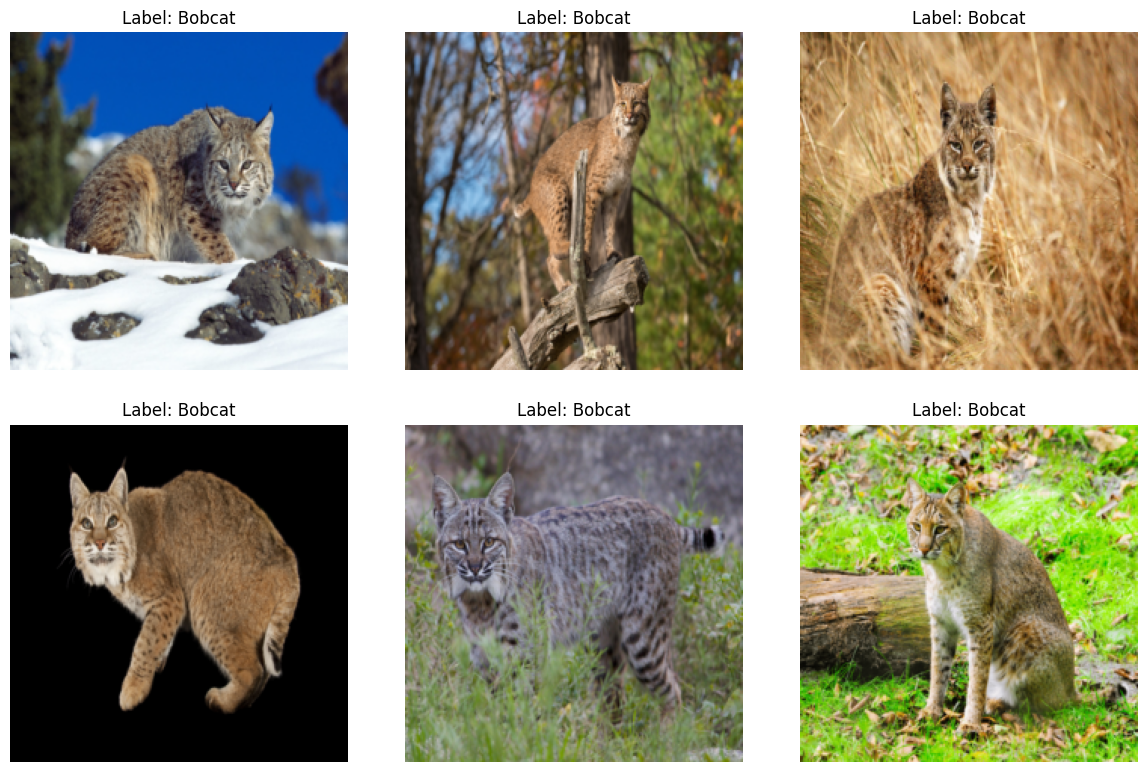

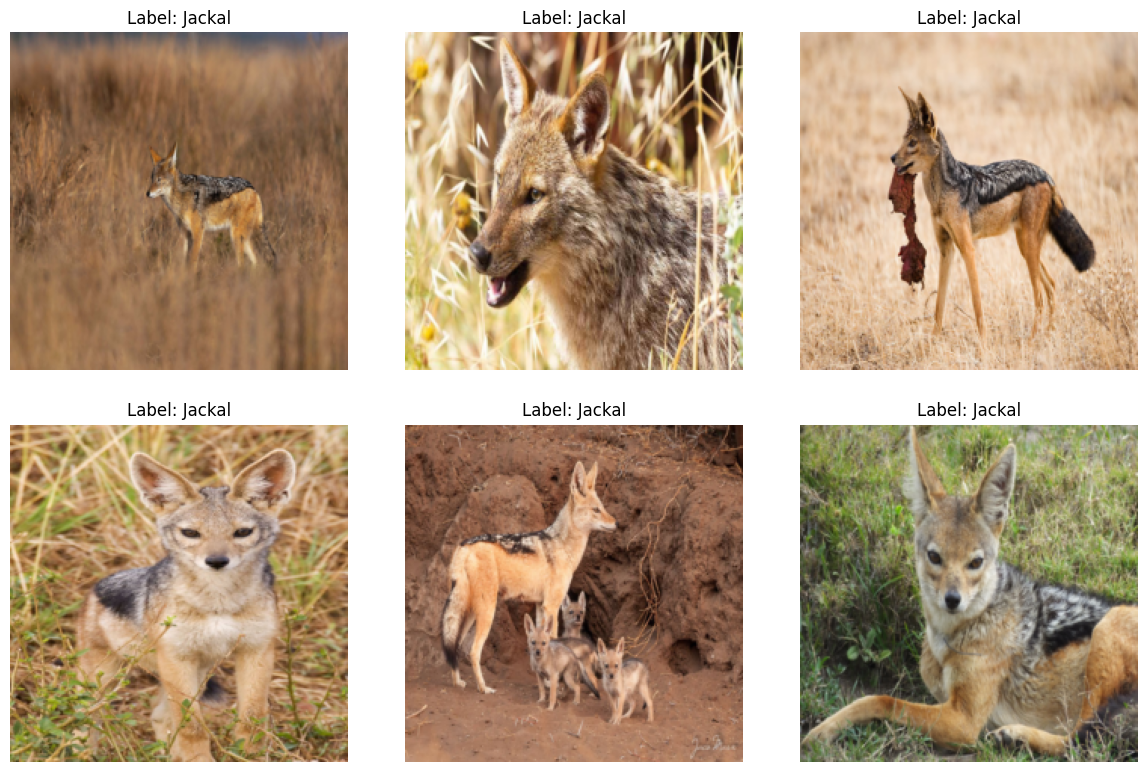

In [5]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import random

random.seed(40)

# Function to display images in a grid
def show_images_grid(tensors, labels, rows=2, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    fig.tight_layout()
    
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    
    for i, (tensor, label) in enumerate(zip(tensors, labels)):
        if i >= rows * cols:
            break
        
        image = tensor * std[:, None, None] + mean[:, None, None]  # Denormalize
        image = image.permute(1, 2, 0)  # Change dimensions to H x W x C
        
        ax = axes[i // cols, i % cols]
        ax.imshow(image.numpy())
        ax.set_title(f'Label: {"Bobcat" if label == 0 else "Jackal"}')
        ax.axis('off')
    
    plt.show()

# Load images and visualize in a grid with random selection
def visualize_dataset_in_grid(data_dir, num_images=6, rows=2, cols=3):
    # Set the random seed for consistency
    
    file_paths = list(Path(data_dir).glob('*.pt'))
    labels = [0 if 'bobcat' in str(path).lower() else 1 for path in file_paths]

    # Shuffle the file paths and labels together
    combined = list(zip(file_paths, labels))
    random.shuffle(combined)
    file_paths, labels = zip(*combined)

    # Select random images based on the shuffled paths
    selected_tensors = [torch.load(file_paths[i]) for i in range(num_images)]
    selected_labels = labels[:num_images]
    
    show_images_grid(selected_tensors, selected_labels, rows=rows, cols=cols)

# Visualize training images for Bobcat and Jackal with random selection
visualize_dataset_in_grid('preprocessed/train/bobcat', num_images=6)
visualize_dataset_in_grid('preprocessed/train/jackal', num_images=6)


#### Creating DataLoader

In [6]:
import torch
from torch.utils.data import DataLoader, Dataset
import os
from pathlib import Path

class PreProcessedDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.file_paths = list(self.data_dir.glob('**/*.pt'))
        self.labels = [0 if 'bobcat' in str(path).lower() else 1 for path in self.file_paths]

        # Debug: Print number of files found
        print(f"Found {len(self.file_paths)} .pt files in {data_dir}")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image_tensor = torch.load(file_path)  # Load the .pt file
        label = self.labels[idx]
        return image_tensor, label

def get_data_loader(data_dir, batch_size = 32):
    dataset = PreProcessedDataset(data_dir)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader


#### Creating Models

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

class VGGCustom(nn.Module):
    def __init__(self, num_blocks=1, num_classes=2):
        super().__init__()
        self.features = self._add_layers(num_blocks)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (224 // (2 ** num_blocks)) * (224 // (2 ** num_blocks)), 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
    
    def _add_layers(self, num_blocks):
        layers = []
        in_channels = 3
        for _ in range(num_blocks):
            layers.append(nn.Conv2d(in_channels, 64, kernel_size=3, padding=1))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = 64
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def create_vgg_model(num_blocks=1, num_classes=2):
    model = VGGCustom(num_blocks=num_blocks, num_classes=num_classes)
    return model

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        training_loss = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        training_loss.append(avg_loss)
        # print(f"Epoch {epoch + 1}/num_epochs, Loss: {avg_loss:0.6f}")
    print(f"Final loss on train set: {training_loss[-1]:.6f}")
    print("Training Complete")
    return model, training_loss

# Main function to set-up and train
def train_VGG1B():
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = create_vgg_model(1, 2).to(device)

    train_loader = get_data_loader('preprocessed/train')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    return train_model(model, train_loader, criterion, optimizer, device, 100)


In [31]:
vgg1b, train_loss_vgg1b = train_VGG1B()

Found 239 .pt files in preprocessed/train


  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/4k/xxxy9tg127s6hyrvg1srwct00000gn/T/ipykernel_75232/406173056.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_

Final loss on train set: 0.302676
Training Complete


In [8]:
def train_VGG3B():
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = create_vgg_model(num_blocks=3).to(device)

    train_loader = get_data_loader('preprocessed/train')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.01)
    return train_model(model, train_loader, criterion, optimizer, device, 100)

vgg3b, train_loss_vgg3b = train_VGG3B()

Found 239 .pt files in preprocessed/train


  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/4k/xxxy9tg127s6hyrvg1srwct00000gn/T/ipykernel_40696/406173056.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_

Final loss on train set: 0.693999
Training Complete


In [11]:
def get_num_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
import torch
import torch.nn.functional as F
import time

def evaluate_model(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = test_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    num_parameters = get_num_parameters(model)
    print(f"Number of parameters in model: {num_parameters}")

    training_time_start = time.time()  # Start timing the training

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Evaluate on test set
        avg_test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {avg_test_loss:.4f}, "
              f"Test Accuracy: {test_accuracy:.2f}%")

    training_time_end = time.time()
    training_time = training_time_end - training_time_start

    print(f"Training complete! Total training time: {training_time:.2f} seconds")

    # Return collected metrics
    return {
        "Training time (s)": training_time,
        "Training loss": avg_train_loss,
        "Training accuracy (%)": train_accuracy,
        "Testing accuracy (%)": test_accuracy,
        "Number of parameters": num_parameters
    }


# Function to plot images with predictions
def plot_predictions(model, data_loader, device, num_images=6):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            for i in range(num_images):
                if images_shown >= num_images:
                    break
                
                # Denormalize and convert the image for plotting
                img = inputs[i].cpu() * torch.tensor([0.229, 0.224, 0.225])[:, None, None] + torch.tensor([0.485, 0.456, 0.406])[:, None, None]
                img = img.permute(1, 2, 0)  # Convert to H x W x C for plotting

                axes[images_shown].imshow(img.numpy())
                axes[images_shown].set_title(f'Pred: {"Bobcat" if predictions[i] == 0 else "Jackal"}')
                axes[images_shown].axis('off')

                images_shown += 1
            
            if images_shown >= num_images:
                break

    plt.show()



Found 239 .pt files in preprocessed/train
Found 60 .pt files in preprocessed/test
Training VGG (1 block)...
Number of parameters in model: 205523458


/var/folders/4k/xxxy9tg127s6hyrvg1srwct00000gn/T/ipykernel_40696/406173056.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_tensor = torch.load(file_path)  # Load 

Epoch 1/10, Train Loss: 86.3341, Train Accuracy: 55.65%, Test Loss: 8.1476, Test Accuracy: 71.67%
Epoch 2/10, Train Loss: 16.2905, Train Accuracy: 70.29%, Test Loss: 11.4732, Test Accuracy: 71.67%
Epoch 3/10, Train Loss: 6.5824, Train Accuracy: 81.59%, Test Loss: 7.7420, Test Accuracy: 71.67%
Epoch 4/10, Train Loss: 3.8774, Train Accuracy: 86.61%, Test Loss: 2.9779, Test Accuracy: 76.67%
Epoch 5/10, Train Loss: 1.5625, Train Accuracy: 94.14%, Test Loss: 1.5595, Test Accuracy: 90.00%
Epoch 6/10, Train Loss: 0.7153, Train Accuracy: 93.72%, Test Loss: 0.4251, Test Accuracy: 96.67%
Epoch 7/10, Train Loss: 0.1153, Train Accuracy: 98.33%, Test Loss: 3.4288, Test Accuracy: 85.00%
Epoch 8/10, Train Loss: 0.0700, Train Accuracy: 99.58%, Test Loss: 0.5405, Test Accuracy: 96.67%
Epoch 9/10, Train Loss: 0.0014, Train Accuracy: 100.00%, Test Loss: 0.1159, Test Accuracy: 96.67%
Epoch 10/10, Train Loss: 0.0151, Train Accuracy: 99.58%, Test Loss: 0.3060, Test Accuracy: 96.67%
Training complete! Total 

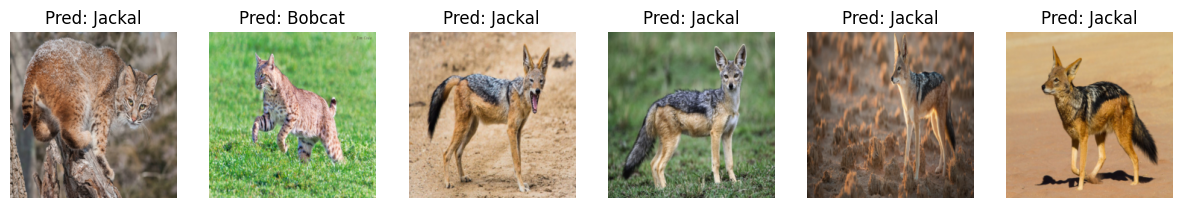


Plotting predictions for VGG (3 blocks)...


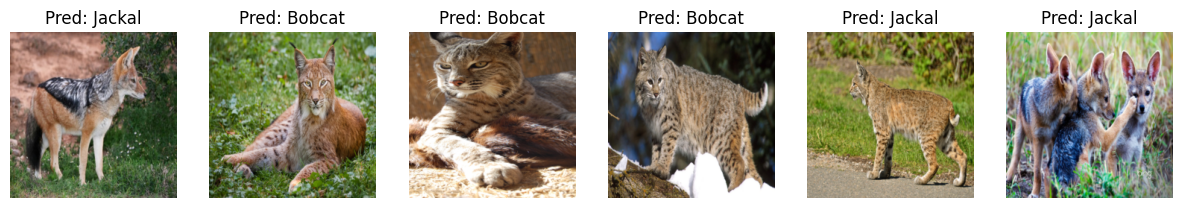

In [15]:

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Create and train VGG (1 block)
model_vgg_1 = create_vgg_model(num_blocks=1).to(device)
train_loader = get_data_loader('preprocessed/train', batch_size=32)
test_loader = get_data_loader('preprocessed/test', batch_size=32)

criterion = nn.CrossEntropyLoss()
optimizer_vgg_1 = optim.Adam(model_vgg_1.parameters(), lr=0.001)
print("Training VGG (1 block)...")
vgg_1_block = train_and_evaluate(model_vgg_1, train_loader, test_loader, criterion, optimizer_vgg_1, device, num_epochs=10)

# Create and train VGG (3 blocks)
model_vgg_3 = create_vgg_model(num_blocks=3).to(device)
optimizer_vgg_3 = optim.Adam(model_vgg_3.parameters(), lr=0.001)
print("\nTraining VGG (3 blocks)...")
vgg_3_block = train_and_evaluate(model_vgg_3, train_loader, test_loader, criterion, optimizer_vgg_3, device, num_epochs=10)

# Plot predictions for both models
print("\nPlotting predictions for VGG (1 block)...")
plot_predictions(model_vgg_1, test_loader, device, num_images=6)

print("\nPlotting predictions for VGG (3 blocks)...")
plot_predictions(model_vgg_3, test_loader, device, num_images=6)


In [20]:
from torchvision import transforms
from PIL import Image
import numpy as np

# Updated function to load data with data augmentation
def get_data_loader_augmented(data_dir, batch_size=32, augment=False):
    if augment:
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),  # Randomly rotate by up to 15 degrees
            # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    dataset = PreProcessedDatasetAug(data_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader

class PreProcessedDatasetAug(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.file_paths = list(self.data_dir.glob('**/*.pt'))
        self.labels = [0 if 'bobcat' in str(path).lower() else 1 for path in self.file_paths]
        self.transform = transform

        # Debug: Print number of files found
        print(f"Found {len(self.file_paths)} .pt files in {data_dir}")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        image_tensor = torch.load(file_path)  # Load the .pt file
        label = self.labels[idx]

        # Convert the tensor to a PIL Image
        image_array = image_tensor.permute(1, 2, 0).numpy()  # Convert to H x W x C format for PIL
        image = Image.fromarray((image_array * 255).astype(np.uint8))  # Convert to uint8 for PIL

        # Apply the transformation if provided
        if self.transform:
            image = self.transform(image)

        return image, label


In [ ]:
def VGG3B_with_augmentation():
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = create_vgg_model(num_blocks=3).to(device)

    # Load training data with augmentation and test data without augmentation
    train_loader = get_data_loader_augmented('preprocessed/train', batch_size=32, augment=True)
    test_loader = get_data_loader_augmented('preprocessed/test', batch_size=32)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train and evaluate the model
    vgg_3_block_augmented = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=1000)

    plot_predictions(model, test_loader, device, num_images=6)
if __name__ == "__main__":
    VGG3B_with_augmentation()


Found 239 .pt files in preprocessed/train
Found 60 .pt files in preprocessed/test
Number of parameters in model: 12921474


/var/folders/4k/xxxy9tg127s6hyrvg1srwct00000gn/T/ipykernel_40696/848338304.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_tensor = torch.load(file_path)  # Load 

Epoch 1/1000, Train Loss: 2.2772, Train Accuracy: 50.21%, Test Loss: 0.7826, Test Accuracy: 50.00%
Epoch 2/1000, Train Loss: 0.7035, Train Accuracy: 48.12%, Test Loss: 0.6932, Test Accuracy: 48.33%
Epoch 3/1000, Train Loss: 0.6934, Train Accuracy: 49.79%, Test Loss: 0.6930, Test Accuracy: 50.00%
Epoch 4/1000, Train Loss: 0.6932, Train Accuracy: 49.79%, Test Loss: 0.6931, Test Accuracy: 50.00%
Epoch 5/1000, Train Loss: 0.6932, Train Accuracy: 49.79%, Test Loss: 0.6932, Test Accuracy: 50.00%
Epoch 6/1000, Train Loss: 0.6933, Train Accuracy: 49.79%, Test Loss: 0.6931, Test Accuracy: 50.00%
Epoch 7/1000, Train Loss: 0.6932, Train Accuracy: 49.79%, Test Loss: 0.6932, Test Accuracy: 50.00%
Epoch 8/1000, Train Loss: 0.6932, Train Accuracy: 49.79%, Test Loss: 0.6931, Test Accuracy: 50.00%
Epoch 9/1000, Train Loss: 0.6932, Train Accuracy: 49.79%, Test Loss: 0.6931, Test Accuracy: 50.00%
Epoch 10/1000, Train Loss: 0.6932, Train Accuracy: 45.19%, Test Loss: 0.6931, Test Accuracy: 50.00%
Epoch 11/